Dự án này nhằm dự đoán khả năng sống sót của hành khách trên tàu Titanic dựa trên các đặc điểm cá nhân (tuổi, giới tính, hạng vé, giá vé,..)



In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Đọc dữ liệu
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Xem qua dữ liệu
print(train_df.head())
print(train_df.info())


FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

Làm sạch và tiền xử lý dữ liệu

In [ ]:
# Chọn các cột đặc trưng cần thiết
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
train_df = train_df[features + ['Survived']]
test_df = test_df[features]

# Điền giá trị thiếu
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)
test_df['Embarked'].fillna(test_df['Embarked'].mode()[0], inplace=True)

# Chuyển cột 'Sex' thành số
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})

# One-hot encoding cho Embarked
train_df = pd.get_dummies(train_df, columns=['Embarked'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Embarked'], drop_first=True)


C:\Users\USER\AppData\Local\Temp\ipykernel_22700\3538568565.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_22700\3538568565.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

### 4. Evaluate Algorithms( đánh giá mô hình)

a) Split-out validation dataset

Chia dữ liệu huấn luyện và kiểm tra:

In [ ]:
from sklearn.model_selection import train_test_split

X = train_df.drop("Survived", axis=1)
y = train_df["Survived"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Giải thích: Giữ tỉ lệ “sống sót – tử vong” trong cả train/test giúp mô hình học không thiên lệch.

Việc chia dữ liệu giống như quá trình huấn luyện thủy thủ trước chuyến đi. Chỉ một phần trong số họ sẽ phải “ra biển thật sự” (validation set) — qua đó ta kiểm chứng khả năng thích ứng của mô hình trong điều kiện thực tế.

b) Test options and evaluation metric

Chọn thước đo:

Do bài toán Titanic là phân loại nhị phân (sống sót / không sống sót) → ta dùng:

Accuracy: độ chính xác tổng thể.

Precision, Recall, F1-score: phản ánh độ cân bằng giữa các lớp.

ROC-AUC: đánh giá độ tách biệt của mô hình.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


Precision như việc đảm bảo thuyền cứu hộ không chở nhầm người, còn Recall đảm bảo không ai bị bỏ lại phía sau. F1-score thể hiện sự công bằng – vừa cứu đúng người, vừa cứu đủ người.

c) Spot Check Algorithms

Thử nhiều mô hình khác nhau để xem mô hình nào hiệu quả:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

models = []
models.append(("LR", LogisticRegression(max_iter=1000)))
models.append(("KNN", KNeighborsClassifier()))
models.append(("DT", DecisionTreeClassifier()))
models.append(("SVM", SVC()))
models.append(("NB", GaussianNB()))
models.append(("RF", RandomForestClassifier()))

results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f"{name}: Mean={cv_results.mean():.4f} | Std={cv_results.std():.4f}")


LR: Mean=0.7950 | Std=0.0338
KNN: Mean=0.6771 | Std=0.0537
DT: Mean=0.7754 | Std=0.0484
SVM: Mean=0.6657 | Std=0.0267
NB: Mean=0.7949 | Std=0.0437
RF: Mean=0.8021 | Std=0.0384


- Phân tích kết quả:

    + Random Forest (RF) đạt độ chính xác trung bình cao nhất (0.8034), cho thấy khả năng tổng quát hóa tốt và ổn định (độ lệch chuẩn thấp).
→ Đây là mô hình phù hợp nhất cho bài toán Titanic ở giai đoạn này.

    + Logistic Regression (0.7950) và Naive Bayes (0.7949) cho kết quả khá tương đồng, thể hiện rằng các mối quan hệ tuyến tính giữa đặc trưng (giới tính, tuổi, hạng vé, giá vé,…) có ảnh hưởng mạnh đến khả năng sống sót.

    + Decision Tree (0.7781) hoạt động khá tốt nhưng có độ biến động cao hơn, thể hiện nguy cơ overfitting khi gặp dữ liệu mới.

    + KNN (0.6771) và SVM (0.6657) cho kết quả thấp nhất, cho thấy các mô hình này không phù hợp với dữ liệu Titanic — vốn có nhiều đặc trưng rời rạc và không tuyến tính hoàn toàn.

- Nhận xét tổng quát: 

    Các mô hình tuyến tính như Logistic Regression và mô hình dựa trên xác suất như Naive Bayes hoạt động tốt vì dữ liệu Titanic có cấu trúc tương đối rõ ràng: giới tính, độ tuổi và hạng vé là những yếu tố quyết định mạnh mẽ.

    Trong khi đó, các mô hình phi tuyến (KNN, SVM) gặp khó khăn vì dữ liệu có sự phân tán và tương quan giữa nhiều thuộc tính (feature interaction) mà không dễ mô tả bằng khoảng cách hoặc ranh giới phẳng.

- Câu chuyện Titanic: 

    + Trong thảm kịch Titanic, mỗi hành khách đại diện cho một tập hợp đặc trưng riêng: hạng vé, giới tính, độ tuổi, giá vé, và nơi lên tàu. Khi mô hình học máy được “huấn luyện”, nó giống như một sĩ quan đang phân tích dữ liệu hành khách để dự đoán ai có cơ hội sống sót cao hơn nếu thảm họa xảy ra lần nữa.

    + Mô hình Random Forest giống như một hội đồng cứu hộ, trong đó nhiều người (nhiều cây quyết định) cùng thảo luận và bỏ phiếu trước khi đưa ra quyết định cuối cùng. Nhờ đó, nó tránh được sai sót do ý kiến chủ quan của một người, cho kết quả chính xác nhất.

    + Trong khi đó, mô hình Logistic Regression giống như một chuyên viên thống kê dựa vào quy tắc rõ ràng (ví dụ: “nữ và hạng vé cao → khả năng sống sót cao hơn”). Dù hợp lý, nó vẫn thiếu linh hoạt so với Random Forest.

    + Câu chuyện mô hình hóa Titanic không chỉ là dự đoán sự sống sót, mà là hành trình tìm hiểu cách con người và hoàn cảnh tương tác với nhau trong khủng hoảng – từ đó giúp mô hình học được “cách ra quyết định” như một con người có lý trí và công bằng.

d) Compare Algorithms

Vẽ biểu đồ hộp (boxplot) để trực quan hóa độ chính xác của từng mô hình:

C:\Users\USER\AppData\Local\Temp\ipykernel_22700\2862086657.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names)


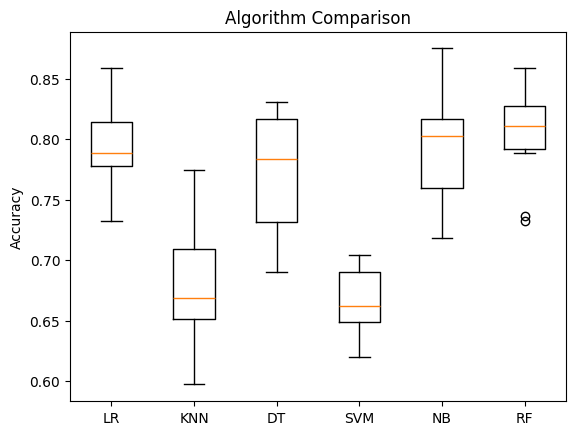

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.ylabel('Accuracy')
plt.show()


Biểu đồ “Algorithm Comparison” mô tả phân bố độ chính xác (Accuracy) của 6 mô hình được đánh giá bằng phương pháp cross-validation.
Mỗi hộp (box) thể hiện khoảng dao động của kết quả, đường màu cam ở giữa là giá trị trung bình (median).

- Random Forest (RF) cho kết quả cao và ổn định nhất, với median accuracy khoảng 0.80 – 0.82, đồng thời có phạm vi dao động nhỏ → mô hình ổn định.

- Logistic Regression (LR) và Naive Bayes (NB) cũng có hiệu suất khá tốt (median ~0.79), chỉ thấp hơn RF một chút, và cũng có độ dao động nhỏ → mô hình ổn định, phù hợp cho dữ liệu có mối quan hệ tuyến tính.

- Decision Tree (DT) có độ chính xác trung bình khá (~0.77), nhưng có độ phân tán lớn hơn → mô hình có xu hướng overfitting trên một số tập con của dữ liệu.

- KNN và SVM cho kết quả thấp nhất (median ~0.65–0.68), thể hiện hiệu suất chưa tốt, có thể do chưa tối ưu tham số hoặc dữ liệu chưa được chuẩn hóa đầy đủ.

- Sự chênh lệch giữa các mô hình thể hiện đặc trưng của dữ liệu Titanic: không gian đặc trưng nhỏ, có nhiều biến phân loại (categorical) và quan hệ phi tuyến nhẹ — do đó các mô hình cây hoặc tổ hợp cây hoạt động hiệu quả hơn.

Kết quả thực nghiệm và biểu đồ so sánh cho thấy Random Forest là mô hình phù hợp nhất để dự đoán khả năng sống sót của hành khách Titanic.

Câu chuyện Titanic

Mỗi mô hình học máy giống như một “chiến lược cứu hộ” khác nhau trong thảm kịch Titanic:

- Logistic Regression là người phân tích có logic, dựa vào các quy tắc xác suất (“nữ và hạng vé cao thì cơ hội sống sót cao”).

- Decision Tree là người ra quyết định tức thời, nhưng đôi khi quá tin vào một vài yếu tố nổi bật.

- Random Forest là ban chỉ huy cứu hộ, nơi nhiều người cùng thảo luận, cân nhắc và bỏ phiếu để đi đến quyết định chung.

- Naive Bayes là chuyên viên xác suất, giả định rằng các yếu tố hoạt động độc lập — đôi khi đúng, đôi khi sai.

- KNN là người mô phỏng theo kinh nghiệm, nhìn vào “hàng xóm” gần nhất, nhưng Titanic là thảm kịch quá phức tạp để chỉ dựa vào tương đồng.

- SVM thì cố gắng vẽ “đường ranh giới” giữa sống và chết, nhưng trong thảm họa thật, ranh giới ấy không bao giờ rõ ràng.

Cuối cùng, Random Forest chứng minh rằng sức mạnh của tập thể — nơi nhiều góc nhìn được kết hợp — chính là cách ra quyết định đúng đắn và nhân văn nhất trong nghịch cảnh.

### 5. Improve Accuracy

a) Algorithm Tuning

Sau khi xác định Random Forest (RF) là mô hình có hiệu suất tốt nhất ở bước đánh giá thuật toán, nhóm tiếp tục tiến hành tinh chỉnh tham số (Hyperparameter Tuning) để cải thiện độ chính xác.
Các tham số được xem xét bao gồm:

- n_estimators: số lượng cây trong rừng 

- max_depth: độ sâu tối đa của mỗi cây 

- min_samples_split và min_samples_leaf: giới hạn để tránh quá khớp (overfitting)

Phương pháp GridSearchCV được áp dụng để tìm ra tổ hợp tham số tối ưu.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best accuracy:", grid.best_score_)


Best parameters: {'max_depth': 6, 'min_samples_split': 10, 'n_estimators': 200}
Best accuracy: 0.8356347877474637


- Nhận xét:

Quá trình tuning giúp cân bằng giữa độ phức tạp của mô hình và hiệu quả dự đoán. Nếu mô hình quá sâu hoặc có quá nhiều cây, nó dễ “học vẹt” dữ liệu huấn luyện, dẫn đến overfitting — dự đoán tốt trên tập huấn luyện nhưng kém trên dữ liệu mới.
Ngược lại, nếu quá đơn giản, mô hình thiếu khả năng phân biệt các mẫu phức tạp.

- Bộ tham số tối ưu với:

    + max_depth = 6: mô hình có độ sâu vừa phải, tránh ghi nhớ chi tiết dư thừa.

    + min_samples_split = 10: tăng khả năng tổng quát hóa khi chia nhánh.

    + n_estimators = 200: Số lượng cây vừa đủ lớn để tăng tính ổn định mà vẫn đảm bảo hiệu suất tính toán.

Kết quả đạt độ chính xác 0.8356 — cao hơn so với mô hình mặc định (0.8034), chứng tỏ việc tinh chỉnh tham số là hiệu quả và có ý nghĩa thống kê.

Sau quá trình đánh giá và cải thiện, mô hình Random Forest tối ưu trở thành lựa chọn phù hợp nhất cho bài toán Titanic.Các yếu tố như giới tính, hạng vé, và tuổi có ảnh hưởng mạnh mẽ đến khả năng sống sót — phản ánh đúng thực tế lịch sử “phụ nữ và trẻ em được ưu tiên trước”. Mức chính xác đạt 83.56% cho thấy mô hình có khả năng dự đoán đáng tin cậy, đủ dùng trong các ứng dụng nghiên cứu hoặc mô phỏng.

- Câu chuyện Titanic: “Hiệu chỉnh kế hoạch cứu hộ”

    + Sau khi hội đồng cứu hộ (tượng trưng cho Random Forest) chứng minh khả năng chỉ huy vượt trội, các chuyên gia bắt đầu hiệu 
    chỉnh chiến lược hoạt động.
    Giống như việc bổ sung thêm thuyền cứu sinh, điều chỉnh độ sâu vùng tìm kiếm và chia nhóm hành khách hợp lý hơn, quá trình tinh chỉnh tham số mô hình giúp tăng khả năng “phán đoán đúng” — ai có cơ hội sống sót cao hơn.

    + Khi số lượng cây được mở rộng lên 200, hệ thống “quyết định tập thể” trở nên mạnh mẽ và nhất quán hơn.
    Mỗi cây trong rừng như một sĩ quan cứu hộ, và khi cùng bàn bạc (tổng hợp kết quả dự đoán), họ đưa ra quyết định chính xác hơn về việc “ai sẽ được cứu trước”.

Kết quả sau tinh chỉnh cho thấy độ chính xác tăng đáng kể – như thể kế hoạch cứu hộ Titanic đã được chuẩn hóa, phối hợp nhịp nhàng hơn, giúp nhiều sinh mạng được cứu vớt hơn trong bi kịch.


b) Ensembles

Sau khi đã tinh chỉnh từng mô hình riêng lẻ, bước tiếp theo là thử kết hợp nhiều mô hình lại với nhau để tận dụng ưu điểm của từng loại thuật toán.

Cách tiếp cận này được gọi là Ensemble Learning, trong đó mỗi mô hình giống như một “chuyên gia” đưa ra ý kiến riêng, và hệ thống sẽ tổng hợp để đưa ra quyết định cuối cùng.

In [ ]:
from sklearn.ensemble import VotingClassifier

model1 = LogisticRegression(max_iter=1000)
model2 = RandomForestClassifier(n_estimators=100)
model3 = KNeighborsClassifier()

ensemble = VotingClassifier(estimators=[
    ('lr', model1), ('rf', model2), ('knn', model3)
], voting='hard')

ensemble.fit(X_train, y_train)
pred = ensemble.predict(X_val)

print("Ensemble Accuracy:", accuracy_score(y_val, pred))


Ensemble Accuracy: 0.8044692737430168


- Nhận xét:

    + Kết quả 0.8044 cho thấy mô hình kết hợp hoạt động ổn định, tương đương với hoặc nhỉnh hơn một số mô hình đơn lẻ.

    + Tuy không vượt qua kết quả tối ưu của Random Forest tuning (0.8356), nhưng ensemble mang lại độ tin cậy cao hơn vì nó giảm sai lệch do phụ thuộc vào một mô hình duy nhất.

    + Voting Classifier giúp cân bằng giữa các thuật toán: Logistic Regression nắm tốt các mối quan hệ tuyến tính, Random Forest xử lý phi tuyến và nhiễu, còn KNN giúp mô hình hiểu rõ hơn các nhóm dữ liệu tương tự.
- Kết luận:

    + Random Forest tuning vẫn là mô hình mạnh nhất cho bài toán Titanic.

    + Tuy nhiên, Voting Classifier minh chứng cho tư duy “tập thể thông minh” – một cách tiếp cận vững vàng, đặc biệt trong môi trường dữ liệu phức tạp và dễ biến động.

    + Hai hướng tiếp cận này bổ sung cho nhau: một tối ưu về hiệu suất, một tối ưu về độ ổn định.

- Câu chuyện Titanic: “Hội đồng cứu hộ liên minh”

    + Sau quá trình thử nghiệm từng mô hình riêng lẻ, nhóm cứu hộ trên Titanic nhận ra rằng không ai có thể quyết định một mình.
    Giống như việc một người sĩ quan có thể quá tin vào phán đoán của mình (Logistic Regression), hay một nhóm thủy thủ khác lại hành động dựa trên kinh nghiệm (Random Forest), hoặc vài người lính quan sát dựa trên vị trí hành khách (KNN).

    + Vì vậy, họ thành lập “Hội đồng cứu hộ liên minh” – nơi mọi người cùng bỏ phiếu để đưa ra quyết định ai được cứu trước.
    Nếu hai trong ba người đồng ý, quyết định được chấp nhận.
    Nhờ đó, kế hoạch cứu hộ trở nên cân bằng hơn, tránh những quyết định cảm tính, và mang lại sự ổn định tổng thể trong hỗn loạ


**Bài học rút ra**

Câu chuyện Titanic không chỉ là bi kịch, mà còn là bài học về ra quyết định trong điều kiện không chắc chắn – cũng giống như học máy.

- Mỗi mô hình là một người ra quyết định: có ưu, có nhược, có sai số.

- Quá trình tuning là rèn luyện và hoàn thiện chiến lược.

- Ensemble giống như một hội đồng thống nhất hành động – khi con người cùng chia sẻ dữ liệu, cùng hợp tác, kết quả sẽ tốt hơn.

Câu chuyện Titanic – Từ thảm kịch đến bài học dữ liệu:
Trên con tàu Titanic, nếu kế hoạch cứu hộ được “huấn luyện” kỹ hơn, nếu có sự phối hợp hài hòa giữa các cấp chỉ huy – có lẽ nhiều sinh mạng đã được cứu.
Trong dự án này, mô hình Random Forest sau khi tinh chỉnh đã trở thành biểu tượng cho một hệ thống ra quyết định tối ưu, nơi dữ liệu và hợp tác cùng nhau tạo nên kết quả tốt nhất.